<a href="https://colab.research.google.com/github/anath703/case-studies/blob/main/Wrangling_the_MLB_2021_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wrangling the MLB 2021 Game Data
The data is piped from a Python package called `pybaseball`. Technically we ought to be using that here too but CSV is easier for most people. First we load the `numpy` and `pandas` packages because we always do that:

In [ ]:
import numpy as np
import pandas as pd

We saved the data on our GitHub. We load directly from the URL:

In [ ]:
url = 'https://github.com/uvasds-sportsanalyticsclub/pythagorean-expectations/raw/main/data/mlb2021.csv'
mlb = pd.read_csv(url)
mlb

,Unnamed: 0,Date,HomeTeam,AwayTeam,RunsHome,RunsAway,Inn,Win,Loss,Save,Time,Attendance
0,7,"Thursday, Apr 8",BAL,BOS,3.0,7.0,9.0,Rodriguez,Harvey,None,3:08,10150.0
1,8,"Saturday, Apr 10",BAL,BOS,4.0,6.0,10.0,Barnes,Tate,Andriese,3:34,9307.0
2,9,"Sunday, Apr 11",BAL,BOS,9.0,14.0,9.0,Pivetta,Lopez,None,3:46,8171.0
3,10,"Tuesday, Apr 13 (1)",BAL,SEA,3.0,4.0,8.0,Montero,Scott,Graveman,2:26,NaN
4,11,"Tuesday, Apr 13 (2)",BAL,SEA,7.0,6.0,7.0,Valdez,Sadler,None,2:38,4147.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2427,148,"Saturday, Sep 18",WSN,COL,0.0,6.0,9.0,Freeland,Corbin,None,3:06,29315.0
2428,149,"Sunday, Sep 19",WSN,COL,3.0,0.0,9.0,Espino,Gray,Finnegan,3:01,26303.0
2429,160,"Friday, Oct 1",WSN,BOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2430,161,"Saturday, Oct 2",WSN,BOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We want to achieve the following goals with the data:

* Calculate the Pythagorean wins for each team

* Create the standings for each team: wins/losses, runs scored and allowed

* We can split these numbers by time: before/after all star game, for example

To do this we need to take care of the following tasks for wrangling the data:

1. We need to get the date column into a date format

2. We need to see who won each game

3. We need to assign wins/losses and runs scored/allowed to each team

## Fixing the date column
Right now the date is of "object" data types:

In [ ]:
mlb.dtypes

Unnamed: 0      int64
Date           object
HomeTeam       object
AwayTeam       object
RunsHome      float64
RunsAway      float64
Inn           float64
Win            object
Loss           object
Save           object
Time           object
Attendance    float64
dtype: object

The first thing we have to is get rid of the (1) and (2) that appears after certain dates on whick double-headers occurred:

In [ ]:
mlb.Date = mlb['Date'].str.replace('\(1\)', '')
mlb.Date = mlb['Date'].str.replace('\(2\)', '')
mlb.Date = mlb['Date'].str.strip() + " 2021"

Now we convert to datetime:

In [ ]:
pd.set_option('display.max_rows', 10)
mlb.Date.value_counts()

Tuesday, Apr 13 2021     17
Saturday, May 29 2021    17
Wednesday, Jul 7 2021    17
Tuesday, Aug 10 2021     17
Sunday, Jul 4 2021       16
                         ..
Monday, Aug 9 2021        4
Monday, Jun 7 2021        3
Thursday, Oct 14 2021     1
Friday, Oct 8 2021        1
Saturday, Oct 9 2021      1
Name: Date, Length: 185, dtype: int64

In [ ]:
mlb.Date = pd.to_datetime(mlb.Date, format='%A, %b %d %Y')

In [ ]:
mlb

In [ ]:
#mlb['afterallstar'] = mlb.Date > pd.to_datetime('7/13/2021')

In [ ]:
mlb = mlb.sort_values(by='Date')
mlb

,Unnamed: 0,Date,HomeTeam,AwayTeam,RunsHome,RunsAway,Inn,Win,Loss,Save,Time,Attendance
567,1,2021-04-01,LAA,CHW,4.0,3.0,9.0,Mayers,Bummer,Iglesias,2:51,13207.0
1700,1,2021-04-01,MIA,TBR,0.0,1.0,9.0,Thompson,Garcia,Castillo,2:44,7062.0
2108,1,2021-04-01,SDP,ARI,8.0,7.0,9.0,Pagan,Young,Melancon,3:26,10350.0
1538,1,2021-04-01,COL,LAD,8.0,5.0,9.0,Gonzalez,Kershaw,Bard,3:46,20570.0
1457,1,2021-04-01,CIN,STL,6.0,11.0,9.0,Gallegos,Castillo,None,3:31,12264.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,162,2021-10-03,ARI,COL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,162,2021-10-03,CHW,DET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1862,163,2021-10-08,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1863,164,2021-10-09,MIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next we need to construct a win/loss indicator:

In [ ]:
mlb['HomeWin'] = (mlb.RunsHome > mlb.RunsAway).astype('int')
mlb['AwayWin'] = (mlb.RunsHome < mlb.RunsAway).astype('int')

In [ ]:
mlb = mlb[['Date', 'HomeTeam', 'AwayTeam', 'RunsHome', 'RunsAway', 'HomeWin', 'AwayWin']]
mlb['RunsAllowedHome'] = mlb.RunsAway
mlb['RunsAllowedAway'] = mlb.RunsHome

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
home = mlb[['Date', 'HomeTeam', 'RunsHome', 'HomeWin', 'RunsAllowedHome']]
away = mlb[['Date', 'AwayTeam', 'RunsAway', 'AwayWin', 'RunsAllowedAway']]
home = home.rename({'HomeTeam':'Team',
                    'RunsHome':'Runs',
                    'HomeWin':'Win',
                    'RunsAllowedHome':'RunsAllowed'}, axis=1)
away = away.rename({'AwayTeam':'Team',
                    'RunsAway':'Runs',
                    'AwayWin':'Win',
                    'RunsAllowedAway':'RunsAllowed'}, axis=1)
teams = home.append(away)
teams = teams.sort_values(by=['Team','Date'])
teams['Loss'] = 1-teams.Win
teams 

,Date,Team,Runs,Win,RunsAllowed,Loss
2108,2021-04-01,ARI,7.0,0,8.0,1
2109,2021-04-02,ARI,2.0,0,4.0,1
2110,2021-04-03,ARI,0.0,0,7.0,1
2111,2021-04-04,ARI,3.0,1,1.0,0
1542,2021-04-06,ARI,10.0,1,8.0,0
...,...,...,...,...,...,...
2430,2021-10-02,WSN,NaN,0,NaN,1
2431,2021-10-03,WSN,NaN,0,NaN,1
1862,2021-10-08,NaN,NaN,0,NaN,1
1863,2021-10-09,NaN,NaN,0,NaN,1


In [ ]:
teams = teams.groupby(['Team', 'Date']).sum() \
  .groupby(level=0).cumsum().reset_index()
teams

,Team,Date,Runs,Win,RunsAllowed,Loss
0,ARI,2021-04-01,7.0,0,8.0,1
1,ARI,2021-04-02,9.0,0,12.0,2
2,ARI,2021-04-03,9.0,0,19.0,3
3,ARI,2021-04-04,12.0,1,20.0,3
4,ARI,2021-04-06,22.0,2,28.0,3
...,...,...,...,...,...,...
4738,WSN,2021-09-28,709.0,65,794.0,93
4739,WSN,2021-09-29,709.0,65,794.0,94
4740,WSN,2021-10-01,709.0,65,794.0,95
4741,WSN,2021-10-02,709.0,65,794.0,96


In [ ]:
#teams['afterallstar'] = teams.Date > pd.to_datetime('7/13/2021')
teams = teams.query('Date < "9/29/2021"')
teams ## I suggest giving students this one

,Team,Date,Runs,Win,RunsAllowed,Loss
0,ARI,2021-04-01,7.0,0,8.0,1
1,ARI,2021-04-02,9.0,0,12.0,2
2,ARI,2021-04-03,9.0,0,19.0,3
3,ARI,2021-04-04,12.0,1,20.0,3
4,ARI,2021-04-06,22.0,2,28.0,3
...,...,...,...,...,...,...
4734,WSN,2021-09-24,695.0,64,771.0,90
4735,WSN,2021-09-25,701.0,64,778.0,91
4736,WSN,2021-09-26,703.0,64,787.0,92
4737,WSN,2021-09-27,708.0,65,791.0,92


In [ ]:
teams.to_csv('pythag_exp_09.29_meeting.csv', index=False)

In [ ]:
teams['winning_percentage'] = teams.Win / (teams.Win + teams.Loss)
teams

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Team,Date,Runs,Win,RunsAllowed,Loss,afterallstar,winning_percentage
0,ARI,2021-04-01,7.0,0,8.0,1,False,0.000000
1,ARI,2021-04-02,9.0,0,12.0,2,False,0.000000
2,ARI,2021-04-03,9.0,0,19.0,3,False,0.000000
3,ARI,2021-04-04,12.0,1,20.0,3,False,0.250000
4,ARI,2021-04-06,22.0,2,28.0,3,False,0.400000
...,...,...,...,...,...,...,...,...
4729,WSN,2021-09-22,685.0,63,761.0,89,True,0.414474
4730,WSN,2021-09-23,688.0,64,763.0,89,True,0.418301
4731,WSN,2021-09-24,695.0,64,771.0,90,True,0.415584
4732,WSN,2021-09-25,701.0,64,778.0,91,True,0.412903


In [ ]:
teams['pyth_exp'] = teams.Runs**2 / (teams.Runs**2 + teams.RunsAllowed**2)
teams

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Team,Date,Runs,Win,RunsAllowed,Loss,afterallstar,winning_percentage,pyth_exp
0,ARI,2021-04-01,7.0,0,8.0,1,False,0.000000,0.433628
1,ARI,2021-04-02,9.0,0,12.0,2,False,0.000000,0.360000
2,ARI,2021-04-03,9.0,0,19.0,3,False,0.000000,0.183258
3,ARI,2021-04-04,12.0,1,20.0,3,False,0.250000,0.264706
4,ARI,2021-04-06,22.0,2,28.0,3,False,0.400000,0.381703
...,...,...,...,...,...,...,...,...,...
4729,WSN,2021-09-22,685.0,63,761.0,89,True,0.414474,0.447586
4730,WSN,2021-09-23,688.0,64,763.0,89,True,0.418301,0.448449
4731,WSN,2021-09-24,695.0,64,771.0,90,True,0.415584,0.448297
4732,WSN,2021-09-25,701.0,64,778.0,91,True,0.412903,0.448079


In [ ]:
?teams.truncate

In [ ]:
before = teams.query('Date <= "7/13/2021"')
before = pd.merge(before, before.groupby('Team').agg({'Date':max}).reset_index(), on='Team')
before = before.query('Date_x == Date_y')
before = before[['Team', 'winning_percentage', 'pyth_exp']]
before = before.rename({'winning_percentage':'winning_percentage_before', 'pyth_exp':'pyth_exp_before'}, axis=1)
before

,Team,winning_percentage_before,pyth_exp_before
90,ARI,0.282609,0.339858
175,ATL,0.494382,0.523130
261,BAL,0.314607,0.344593
350,BOS,0.604396,0.565163
439,CHC,0.488889,0.469260
...,...,...,...
2275,STL,0.488889,0.447238
2364,TBR,0.588889,0.605710
2454,TEX,0.388889,0.426376
2538,TOR,0.517241,0.587554


In [ ]:
after = pd.merge(teams, teams.groupby('Team').agg({'Date':max}).reset_index(), on='Team')
after = after.query('Date_x == Date_y')
after = after[['Team', 'winning_percentage', 'pyth_exp']]
after = after.rename({'winning_percentage':'winning_percentage_after', 'pyth_exp':'pyth_exp_after'}, axis=1)
after

,Team,winning_percentage_after,pyth_exp_after
154,ARI,0.320513,0.360534
303,ATL,0.529032,0.585329
455,BAL,0.320513,0.327682
606,BOS,0.564103,0.550429
758,CHC,0.429487,0.406023
...,...,...,...
3948,STL,0.551282,0.524046
4103,TBR,0.615385,0.627800
4258,TEX,0.358974,0.365310
4406,TOR,0.551282,0.616002


In [ ]:
compare = pd.merge(before, after, on="Team")
compare

,Team,winning_percentage_before,pyth_exp_before,winning_percentage_after,pyth_exp_after
0,ARI,0.282609,0.339858,0.320513,0.360534
1,ATL,0.494382,0.523130,0.529032,0.585329
2,BAL,0.314607,0.344593,0.320513,0.327682
3,BOS,0.604396,0.565163,0.564103,0.550429
4,CHC,0.488889,0.469260,0.429487,0.406023
...,...,...,...,...,...
25,STL,0.488889,0.447238,0.551282,0.524046
26,TBR,0.588889,0.605710,0.615385,0.627800
27,TEX,0.388889,0.426376,0.358974,0.365310
28,TOR,0.517241,0.587554,0.551282,0.616002


In [ ]:
compare['underperform_before'] =  compare.pyth_exp_before - compare.winning_percentage_before
compare['improvement'] = compare.winning_percentage_after - compare.winning_percentage_before
compare

,Team,winning_percentage_before,pyth_exp_before,winning_percentage_after,pyth_exp_after,underperform_before,improvement
0,ARI,0.282609,0.339858,0.320513,0.360534,0.057250,0.037904
1,ATL,0.494382,0.523130,0.529032,0.585329,0.028748,0.034650
2,BAL,0.314607,0.344593,0.320513,0.327682,0.029986,0.005906
3,BOS,0.604396,0.565163,0.564103,0.550429,-0.039233,-0.040293
4,CHC,0.488889,0.469260,0.429487,0.406023,-0.019629,-0.059402
...,...,...,...,...,...,...,...
25,STL,0.488889,0.447238,0.551282,0.524046,-0.041651,0.062393
26,TBR,0.588889,0.605710,0.615385,0.627800,0.016821,0.026496
27,TEX,0.388889,0.426376,0.358974,0.365310,0.037487,-0.029915
28,TOR,0.517241,0.587554,0.551282,0.616002,0.070312,0.034041


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Text(0, 0.5, 'How much did the team improve between the all star break and the end of the season?')

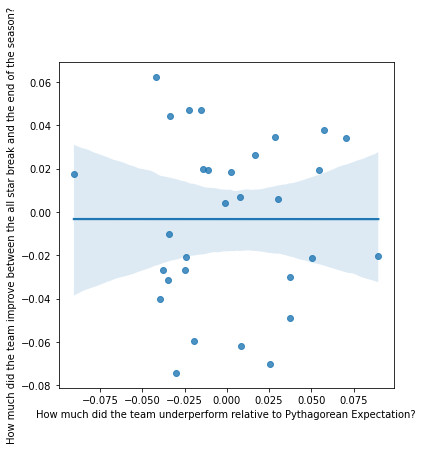

In [ ]:
plt.figure(figsize = (6,6))
sns.regplot(x = 'underperform_before', y = 'improvement', data = compare)
plt.xlabel('How much did the team underperform relative to Pythagorean Expectation?')
plt.ylabel('How much did the team improve between the all star break and the end of the season?')